In [55]:
import os
import tensorflow as tf

def extract_family_genus_and_species_from_path(path):
    # TensorFlow operation to extract the folder name from the full path
    parts = tf.strings.split(path, os.sep)
    folder_name = parts[
        -2
    ]  # Assumes the structure '/.../family_genus_species/image.jpg'

    # Split the folder name assuming the format "family_genus_species"
    family_genus_species = tf.strings.split(folder_name, "_")
    family = family_genus_species[-3]
    genus = family_genus_species[-2]
    species = family_genus_species[-2] + " " + family_genus_species[-1]

    return family, genus, species

def process_path(path, family_labels, genus_labels, species_labels):
    # Load the raw data from the file as a string
    img = tf.io.read_file(path)

    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image to the desired size
    img = tf.image.resize(img, [299, 299])

    # Get the family, genus, and species labels
    family, genus, species = extract_family_genus_and_species_from_path(path)

    # Convert family, genus, and species to indices
    family_label = tf.argmax(tf.equal(family_labels, family))
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))

    # Convert to one-hot encoded format
    family_label = tf.one_hot(family_label, len(family_labels))
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    # Return the image and a dictionary of labels with matching keys
    return img, {
        "family": family_label,
        "genus": genus_label,
        "species": species_label
    }

def build_dataset(directory, batch_size=32):
    # Get list of all files and extract labels
    file_paths = []
    family_labels = set()
    genus_labels = set()
    species_labels = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

                # Extract family, genus, and species
                folder_name = os.path.basename(os.path.dirname(file_path))
                family, genus, species = folder_name.split("_")

                species = genus + " " + species

                # Collect unique family, genus, and species names
                family_labels.add(family)
                genus_labels.add(genus)
                species_labels.add(species)

    # Convert sets to sorted lists to keep label indices consistent
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    # Create a TensorFlow dataset from the file paths
    path_ds = tf.data.Dataset.from_tensor_slices(file_paths)

    # Convert family, genus, and species labels to TensorFlow tensors
    family_labels = tf.constant(family_labels)
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(
        lambda x: process_path(x, family_labels, genus_labels, species_labels),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(file_paths))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return (
        image_label_ds,
        family_labels.numpy().tolist(),
        genus_labels.numpy().tolist(),
        species_labels.numpy().tolist(),
    )

# Usage
train_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/train"
)
valid_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid"
)
test_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test"
)

In [56]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [57]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def compute_class_weights(labels):
    """Compute class weights for a given set of labels."""
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return dict(enumerate(class_weights))

# Example usage: Compute class weights for each level.
family_weights = compute_class_weights([np.argmax(label) for _, labels in train_ds for label in labels['family'].numpy()])
genus_weights = compute_class_weights([np.argmax(label) for _, labels in train_ds for label in labels['genus'].numpy()])
species_weights = compute_class_weights([np.argmax(label) for _, labels in train_ds for label in labels['species'].numpy()])

2024-10-18 16:23:19.922881: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
import tensorflow as tf

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of categorical cross-entropy.
    
    Args:
        weights (dict): A dictionary mapping class indices (integers) to weight values.
    
    Returns:
        A loss function that applies the specified weights.
    """
    weights = tf.constant([weights[i] for i in range(len(weights))], dtype=tf.float32)

    def loss(y_true, y_pred):
        # Calculate the standard categorical cross-entropy loss.
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        # Multiply each loss by the corresponding class weight.
        sample_weights = tf.reduce_sum(y_true * weights, axis=-1)
        return ce_loss * sample_weights

    return loss

In [58]:
# Model preprocess
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        #tf.keras.layers.RandomCrop(224, 224),
        tf.keras.layers.GaussianNoise(0.1),
    ]
)

In [59]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2

# Base model for EfficientNetV2
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False, weights="imagenet", input_shape=(299, 299, 3)
)

# Non-trainable layers (you can later fine-tune by setting this to True)
base_model.trainable = False

In [60]:
# Add custom layers for LCPL.
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs) 
x = preprocess_input(x) 
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Family Classifier
x_family = tf.keras.layers.Dense(512, kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
x_family = tf.keras.layers.BatchNormalization()(x_family)
x_family = tf.keras.layers.LeakyReLU()(x_family)
x_family = tf.keras.layers.Dropout(0.2)(x_family)
family_output = tf.keras.layers.Dense(len(family_labels), activation='softmax', name='family')(x_family)

# Genus Classifier
genus_input = tf.keras.layers.Concatenate()([x, family_output])
x_genus = tf.keras.layers.Dense(128, kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(genus_input)
x_genus = tf.keras.layers.BatchNormalization()(x_genus)
x_genus = tf.keras.layers.LeakyReLU()(x_genus)
x_genus = tf.keras.layers.Dropout(0.2)(x_genus)
genus_output = tf.keras.layers.Dense(len(genus_labels), activation='softmax', name='genus')(x_genus)

# Species Classifier
species_input = tf.keras.layers.Concatenate()([x, genus_output])
x_species = tf.keras.layers.Dense(128, kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(species_input)
x_species = tf.keras.layers.BatchNormalization()(x_species)
x_species = tf.keras.layers.LeakyReLU()(x_species)
x_species = tf.keras.layers.Dropout(0.2)(x_species)
species_output = tf.keras.layers.Dense(len(species_labels), activation='softmax', name='species')(x_species)

# Define the model with multiple outputs.
model = tf.keras.Model(inputs=inputs, outputs=[family_output, genus_output, species_output])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={
        #'family': weighted_categorical_crossentropy(family_weights),
        #'genus': weighted_categorical_crossentropy(genus_weights),
        #'species': weighted_categorical_crossentropy(species_weights),
        'family': 'categorical_crossentropy',
        'genus': 'categorical_crossentropy',
        'species': 'categorical_crossentropy',
    },
    loss_weights={'family': 0.5, 'genus': 1.0, 'species': 1.0},
    metrics={
        'family': ['accuracy'],
        'genus': ['accuracy'],
        'species': ['accuracy']
    }
)

In [53]:
# Add custom layers for LCPL.
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs) 
x = preprocess_input(x) 
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

def residual_block(x, units, l1=0.001, l2=0.001):
    shortcut = x  # Save the input for the residual connection.

    # Dense layer with BatchNorm and activation.
    x = tf.keras.layers.Dense(units, kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Second Dense layer with BatchNorm.
    x = tf.keras.layers.Dense(units, kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Adjust shortcut to match the output shape if necessary.
    if shortcut.shape[-1] != units:
        shortcut = tf.keras.layers.Dense(units, kernel_regularizer=l1_l2(l1=l1, l2=l2))(shortcut)

    # Add the shortcut (residual connection).
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.LeakyReLU()(x)  # Apply activation after adding the shortcut.
    return x

# Family Classifier with residual blocks.
x_family = residual_block(x, 512)
x_family = residual_block(x_family, 256)
family_output = tf.keras.layers.Dense(len(family_labels), activation='softmax', name='family')(x_family)

# Genus Classifier with residual blocks.
#genus_input = tf.keras.layers.Concatenate()([x, family_output])
x_genus = residual_block(family_output, 128)
x_genus = residual_block(x_genus, 64)
genus_output = tf.keras.layers.Dense(len(genus_labels), activation='softmax', name='genus')(x_genus)

# Species Classifier with residual blocks.
#species_input = tf.keras.layers.Concatenate()([x, genus_output])
x_species = residual_block(genus_output, 128)
x_species = residual_block(x_species, 64)
species_output = tf.keras.layers.Dense(len(species_labels), activation='softmax', name='species')(x_species)

# Define the model with multiple outputs.
model = tf.keras.Model(inputs=inputs, outputs=[family_output, genus_output, species_output])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={
        # 'family': weighted_categorical_crossentropy(family_weights),
        # 'genus': weighted_categorical_crossentropy(genus_weights),
        # 'species': weighted_categorical_crossentropy(species_weights),
        'family': 'categorical_crossentropy',
        'genus': 'categorical_crossentropy',
        'species': 'categorical_crossentropy',
    },
    loss_weights={'family': 0.5, 'genus': 1.0, 'species': 1.0},
    metrics={
        'family': ['accuracy'],
        'genus': ['accuracy'],
        'species': ['accuracy']
    }
)

model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 299, 299,  │          0 │ input_layer_21[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 10, 10,    │  5,919,312 │ sequential_3[0][… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_116 (Dense)   │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_116[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_85      │ (None, 512)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 512)       │          0 │ leaky_re_lu_85[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_117 (Dense)   │ (None, 512)       │    262,656 │ dropout_55[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_117[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_118 (Dense)   │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 512)       │          0 │ batch_normalizat… │
│                     │                   │            │ dense_118[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_86      │ (None, 512)       │          0 │ add_31[0][0]      │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_119 (Dense)   │ (None, 256)       │    131,328 │ leaky_re_lu_86[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_119[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_87      │ (None, 256)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 256)       │          0 │ leaky_re_lu_87[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_120 (Dense)   │ (None, 256)       │     65,792 │ dropout_56[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,933,640 (30.26 MB)

 Trainable params: 2,009,720 (7.67 MB)

 Non-trainable params: 5,923,920 (22.60 MB)

In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime

epochs = 30

# Set the directory for checkpoints and TensorBoard logs
checkpoint_dir = "/Users/leonardo/Documents/Projects/cryptovision/models"
log_dir = os.path.join(checkpoint_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Create the directory if it does not exist
os.makedirs(checkpoint_dir, exist_ok=True)


# Define callbacks
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "lcpl_model_v2.keras"),
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)


history = model.fit(
    train_ds, 
    validation_data=valid_ds,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr, checkpoint_callback, tensorboard_callback],
)

Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - family_accuracy: 0.0672 - family_loss: 1.6811 - genus_accuracy: 0.0210 - genus_loss: 4.2310 - loss: 41.2500 - species_accuracy: 0.0211 - species_loss: 4.3991
Epoch 1: val_loss improved from inf to 39.62754, saving model to /Users/leonardo/Documents/Projects/cryptovision/models/lcpl_model_v2.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 71s 307ms/step - family_accuracy: 0.0674 - family_loss: 1.6805 - genus_accuracy: 0.0210 - genus_loss: 4.2306 - loss: 41.2479 - species_accuracy: 0.0211 - species_loss: 4.3987 - val_family_accuracy: 0.2231 - val_family_loss: 1.3046 - val_genus_accuracy: 0.0387 - val_genus_loss: 3.7704 - val_loss: 39.6275 - val_species_accuracy: 0.0228 - val_species_loss: 3.9673 - learning_rate: 1.0000e-05
Epoch 2/30
 39/181 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - family_accuracy: 0.1961 - family_loss: 1.3548 - genus_accuracy: 0.0305 - genus_loss: 4.0137 - loss: 40.0512 - species_accuracy: 0.0392 - species_loss: 4.1204

KeyboardInterrupt: 

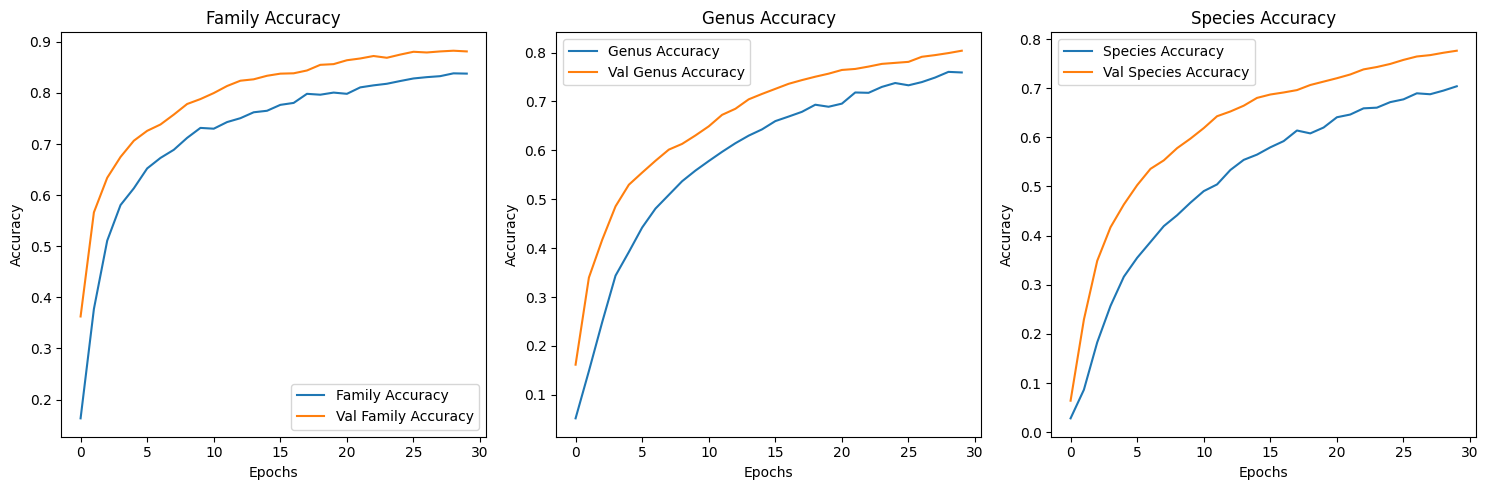

In [20]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    metrics = ["accuracy"]  # , 'AUC', 'Precision', 'Recall']

    for metric in metrics:
        
        plt.figure(figsize=(15, 5))
        
        # Plot for Family
        plt.subplot(1, 3, 1)
        plt.plot(
            history.history[f"family_{metric}"], label=f"Family {metric.capitalize()}"
        )
        plt.plot(
            history.history[f"val_family_{metric}"],
            label=f"Val Family {metric.capitalize()}",
        )
        plt.title(f"Family {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()

        # Plot for Genus
        plt.subplot(1, 3, 2)
        plt.plot(
            history.history[f"genus_{metric}"], label=f"Genus {metric.capitalize()}"
        )
        plt.plot(
            history.history[f"val_genus_{metric}"],
            label=f"Val Genus {metric.capitalize()}",
        )
        plt.title(f"Genus {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()

        # Plot for Species
        plt.subplot(1, 3, 3)
        plt.plot(
            history.history[f"species_{metric}"], label=f"Species {metric.capitalize()}"
        )
        plt.plot(
            history.history[f"val_species_{metric}"],
            label=f"Val Species {metric.capitalize()}",
        )
        plt.title(f"Species {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()

        plt.tight_layout()
        plt.show()


# Assuming you have trained your model and stored the history
plot_training_history(history)

In [21]:
prediction_metrics = model.evaluate(test_ds)

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - family_accuracy: 0.8859 - family_loss: 0.2040 - genus_accuracy: 0.8036 - genus_loss: 0.7189 - loss: 39.7969 - species_accuracy: 0.7916 - species_loss: 0.8567


In [27]:
import numpy as np
import tensorflow as tf


def predict_image(image_path, model, family_labels, genus_labels, species_labels, top_k=3):
    """
    Predict the top-k genus and species from an image using a trained model.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict genus and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [
        (species_labels[i], species_preds[0][i]) for i in top_k_species_indices
    ]

    return top_k_family, top_k_genus, top_k_species


# Example usage
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Pseudochromidae_Cypho_purpurascens/52551_web_Cypho_purpurascens_151.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/70108_web_Eviota_melasma_52.jpeg'
# image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/fish_photo_1050.jpeg'
image_path = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Blenniidae_Ecsenius_stictus/94362_web_Ecsenius_stictus_8.jpeg"
# image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Gobiodon_quinquestrigatus/59583_web_Gobiodon_quinquestrigatus_56.jpeg'
# image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_13.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Tripterygiidae_Enneapterygius_tutuilae/web_Enneapterygius_tutuilae_3.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Blenniidae_Ecsenius_pulcher/fish_photo_17597.jpeg'
#
#image_path = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Aioliops_megastigma/97261_web_Aioliops_megastigma_21.jpeg"
# image_path = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Tripterygiidae_Helcogramma_fuscopinna/web_Helcogramma_fuscopinna_25.jpeg"



top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=3
)

print("Top 3 Family Predictions:")
for family, confidence in top_k_family:
    print(f"{family}: {confidence:.4f}")

print("\nTop 3 Genus Predictions:")
for genus, confidence in top_k_genus:
    print(f"{genus}: {confidence:.4f}")

print("\nTop 3 Species Predictions:")
for species, confidence in top_k_species:
    print(f"{species}: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Top 3 Family Predictions:
b'Blenniidae': 0.4949
b'Gobiidae': 0.4421
b'Syngnathidae': 0.0562

Top 3 Genus Predictions:
b'Ecsenius': 0.4900
b'Paragobiodon': 0.1412
b'Eviota': 0.0997

Top 3 Species Predictions:
b'Ecsenius stictus': 0.6021
b'Paragobiodon modestus': 0.1281
b'Gobiodon quinquestrigatus': 0.0736
